# for visulaization pipepline before training
## Original spectra, historgam
## outlier removal , its mahanlobis distance, and scatter plot after it
## Show spectra after removing outlier and its histogram
## show training data historgram and its spectra
## show testing data histogram and its spectra

## show lds weights plot

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from scipy import signal as sg
from scipy.signal import savgol_filter
from scipy.stats import chi2
from scipy.ndimage import convolve1d
from scipy.ndimage import gaussian_filter1d

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import sklearn.metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import EmpiricalCovariance, MinCovDet

#### preprocessing functions

In [ ]:
def moving_smoothing(input_array, window_length):

    m_rows = len(range(window_length, input_array.shape[1] - window_length))
    m_cols = 2*window_length
    matrix = np.zeros((m_rows,m_cols),dtype=int)
    for j in range(0, len(matrix)):
        k = j+1
        matrix[j] = [x for x in range(k,k+2*window_length)]
    #Smoothing spectra using matrix operations:
    n_cols = m_rows
    newspectra = np.zeros((len(input_array),n_cols))
    for i in range(len(matrix)):
        newspectra[:,i] = np.mean(input_array[: ,matrix[i]],axis=1)
    #Add front and end tails (not smoothed):
    #new_spectra = np.asarray(newspectra)
    fronttail = newspectra[:,:1]
    endtail = newspectra[:,-1:]
    for k in range(1,window_length):
        fronttail=np.append(fronttail,newspectra[:,:1], axis=1)
        endtail = np.append(endtail,newspectra[:,-1:], axis =1)
    data = np.concatenate((fronttail, newspectra, endtail), axis=1)
    return data

def derivate_first(input_array, window_length, polyorder):
    der1 = savgol_filter(input_array, window_length, polyorder,deriv = 1)
    return der1

def MSC(input_array, reference = None):
    ''' Perform Multiplicative scatter correction'''

    #Mean correction
    for i in range(input_array.shape[0]):
        input_array[i,:] -= input_array[i,:].mean()

    # Get the reference spectrum. If not given, estimate from the mean    
    if reference is None:    
        # Calculate mean
        ref = np.mean(input_array, axis=0)
    else:
        ref = reference

    # Define a new data matrix and populate it with the corrected data    
    output_data = np.zeros_like(input_array)
    for i in range(input_array.shape[0]):
        # Run regression
        fit = np.polyfit(ref, input_array[i,:], 1, full=True)
        # Apply correction
        output_data[i,:] = (input_array[i,:] - fit[0][1]) / fit[0][0] 
    #print(fit)
    return output_data

def detrending(input_array):
    X = np.arange(input_array.shape[1])
    base = np.zeros((len(input_array),len(X)))
    for i in range(len(input_array)):
        c = np.polyfit(X, input_array[i], 2)
        base[i] = np.polyval(c, X)
    #Baseline removal
    base_remove = input_array - base
    return base_remove

def savitzky(input_array, window_length, polyorder):
    savgol = savgol_filter(input_array, window_length, polyorder)
    return savgol

def get_lds_kernel_window(kernel, ks, sigma):
    assert kernel in ['gaussian', 'triang', 'laplace']
    half_ks = (ks - 1) // 2
    if kernel == 'gaussian':
        base_kernel = [0.] * half_ks + [1.] + [0.] * half_ks
        kernel_window = gaussian_filter1d(base_kernel, sigma=sigma) / max(gaussian_filter1d(base_kernel, sigma=sigma))
    elif kernel == 'triang':
        kernel_window = triang(ks)
    else:
        laplace = lambda x: np.exp(-abs(x) / sigma) / (2. * sigma)
        kernel_window = list(map(laplace, np.arange(-half_ks, half_ks + 1))) / max(map(laplace, np.arange(-half_ks, half_ks + 1)))

    return kernel_window

In [82]:
#function for Standard Normal Variate
def snv(input_data):          
    # Define a new array and populate it with the corrected data        
    output_data = np.zeros_like(input_data)      
    for i in range(input_data.shape[0]):            
        # Apply correction          
        output_data[i,:] = (input_data[i,:] - np.mean(input_data[i,:])) / np.std(input_data[i,:])        
    return output_data


In [5]:
def get_weights(l,w,s):
    lds_kernel_window = get_lds_kernel_window('gaussian',w, s)
    smoothed_value = convolve1d(np.asarray(l),weights = lds_kernel_window,mode='constant')
    weights = [np.float32(1 / x) for x in smoothed_value]
    scaling = len(weights) / np.sum(weights)
    weights = [scaling * x for x in weights]
    return weights,smoothed_value,lds_kernel_window

In [8]:
def histo(data,r1,r2):
    data.hist(bins=(r2-r1),figsize=(18,9))
    y = np.zeros(r2-r1,dtype=np.int32)
    labels = data.values
    for label in labels:
        y[int(label)-r1]+=1
    plt.figure(figsize=(18,9))
    plt.plot(np.arange(r1,r2),y)
    #plt.hist(y,bins=r2-r1)
    #value_dict = {x:0 for x in range(r1,r2)}
    #labels = data.values
    #for label in labels:
        #value_dict[int(label)]+=1
    #plt.plot(list(value_dict.keys()),list(value_dict.values()))
    

In [6]:
def scat_plot(t0,t1,color):
    fig = plt.figure(figsize=(15,15))
    with plt.style.context(('ggplot')):
        plt.scatter(t0, t1, c = color, s=60)
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.title('Score Plot')
    plt.show()

In [151]:
def derivate_sec(input_array, window_length, polyorder):
    der1 = savgol_filter(input_array, window_length, polyorder,deriv = 2)
    return der1

### orignal spectra and histogram

In [38]:
sed = 100
r1 = 7.5
r2 = 15.5
df = pd.read_csv('DORB.csv')
col = ['sample','800','moisture','ash','protein','ss','oil']
d_asta = df.drop(columns=col)
d_asta = d_asta.dropna(subset=['fiber'])
plant_list = [*set(d_asta['plant'])]
d_asta['fiber'] = d_asta['fiber'].round(1)
d_asta = d_asta[d_asta['fiber']>=r1]
d_asta = d_asta[d_asta['fiber']<r2]

In [39]:
plant_list

['SATARA FEEDS',
 'SACHIN FEEDS',
 '0',
 'GAJANAN FEEDS',
 'HUBLI FEEDS',
 'MIRAJ FEEDS',
 'KOLHAPUR FEEDS',
 'VAGHASI FEEDS',
 'DHULE FEEDS',
 'VARANASI FEEDS',
 'MORYA FEEDS',
 'POLLACHI FEEDS',
 'RBE-KOP-344',
 'TUMKUR FEEDS',
 'ERODE FEEDS',
 'MEDCHAL FEEDS']

In [49]:
from matplotlib.pyplot import cm
from matplotlib import colors as clr

In [59]:
dic ={}
l = len(plant_list)
color = cm.hsv(np.linspace(0,1,l))
for i in range(l):
    dic[plant_list[i]] = clr.to_hex(color[i],keep_alpha = True)

In [60]:
dic

{'SATARA FEEDS': '#ff0000ff',
 'SACHIN FEEDS': '#ff6400ff',
 '0': '#ffc900ff',
 'GAJANAN FEEDS': '#d1ff00ff',
 'HUBLI FEEDS': '#6cff00ff',
 'MIRAJ FEEDS': '#08ff00ff',
 'KOLHAPUR FEEDS': '#00ff5cff',
 'VAGHASI FEEDS': '#00ffc1ff',
 'DHULE FEEDS': '#00d9ffff',
 'VARANASI FEEDS': '#0074ffff',
 'MORYA FEEDS': '#0010ffff',
 'POLLACHI FEEDS': '#5400ffff',
 'RBE-KOP-344': '#b900ffff',
 'TUMKUR FEEDS': '#ff00e1ff',
 'ERODE FEEDS': '#ff007cff',
 'MEDCHAL FEEDS': '#ff0018ff'}

In [42]:
d_asta['fiber'].min() , d_asta['fiber'].max()

(7.5, 15.4)

<AxesSubplot:>

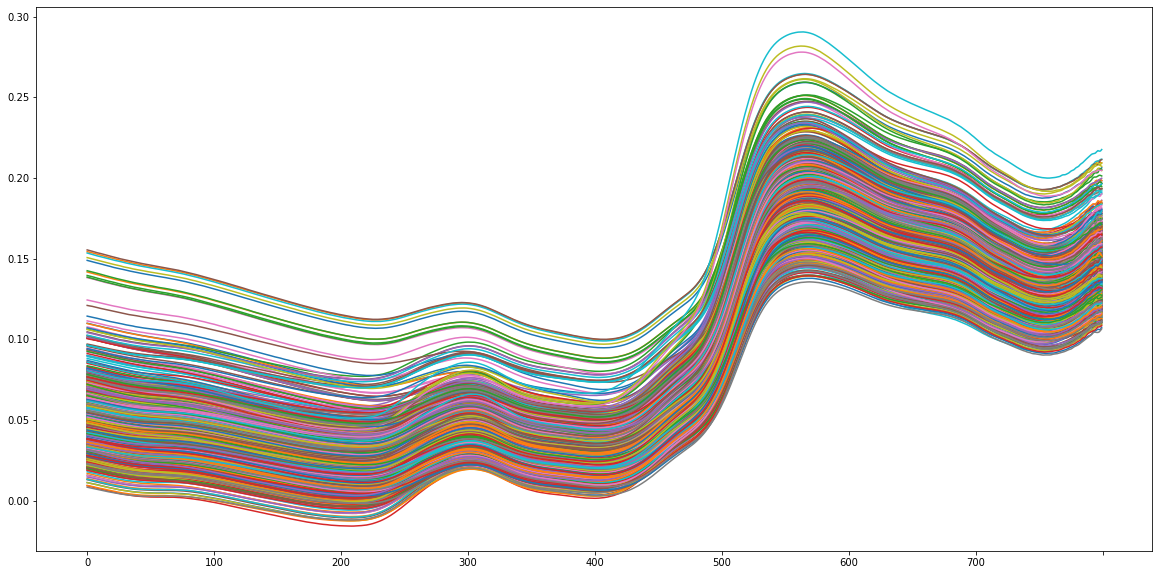

In [43]:
d_asta.drop(columns = ['fiber','plant']).transpose().plot(figsize=(20,10),legend = False)

<AxesSubplot:>

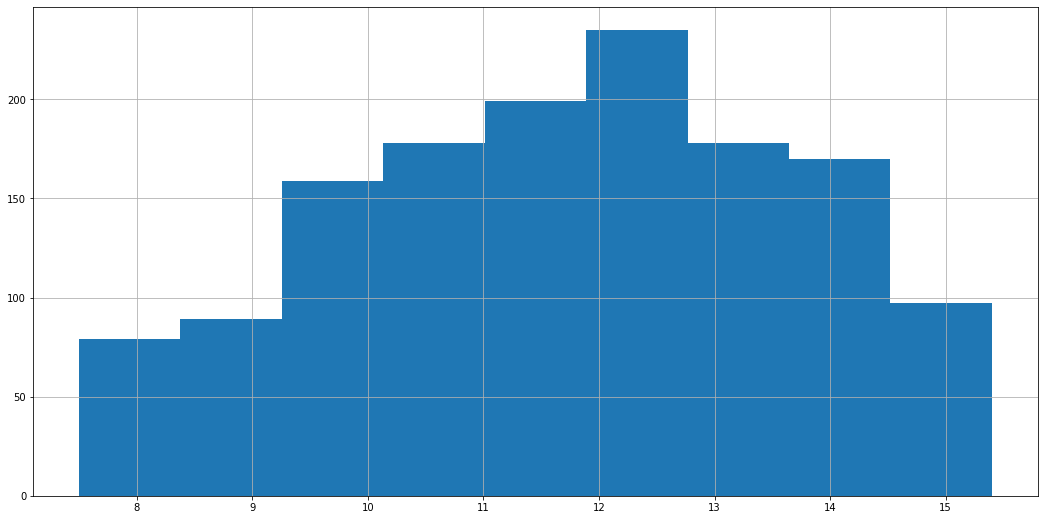

In [44]:
d_asta['fiber'].hist(bins = (round(r2-r1)+1),figsize=(18,9))

In [61]:
for key,value in dic.items():
    d_asta.loc[d_asta['plant'].str.match(key),'color'] = value

### Outlier Removal

visualizing outlier using mahanlobis distance

 ...]

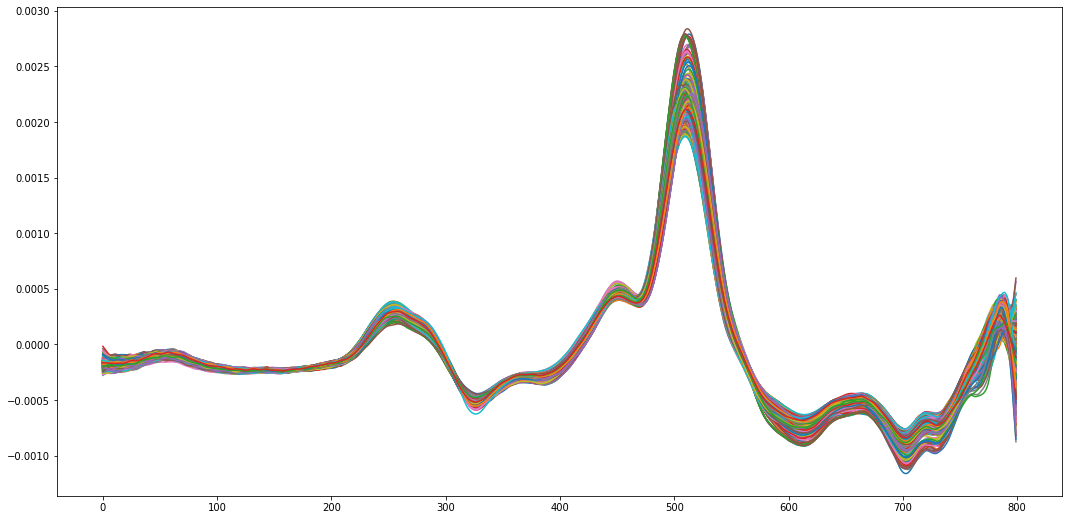

In [55]:
X_val = np.array(d_asta.drop(columns =['fiber','plant','color']))
X_val = savitzky(X_val,11,2)
X_val = MSC(X_val)
X_val = detrending(X_val)
X_val = derivate_first(X_val,11,2)

fig = plt.figure(figsize=(18,9))
a = fig.add_subplot(1,1,1)
a.plot(X_val.transpose())

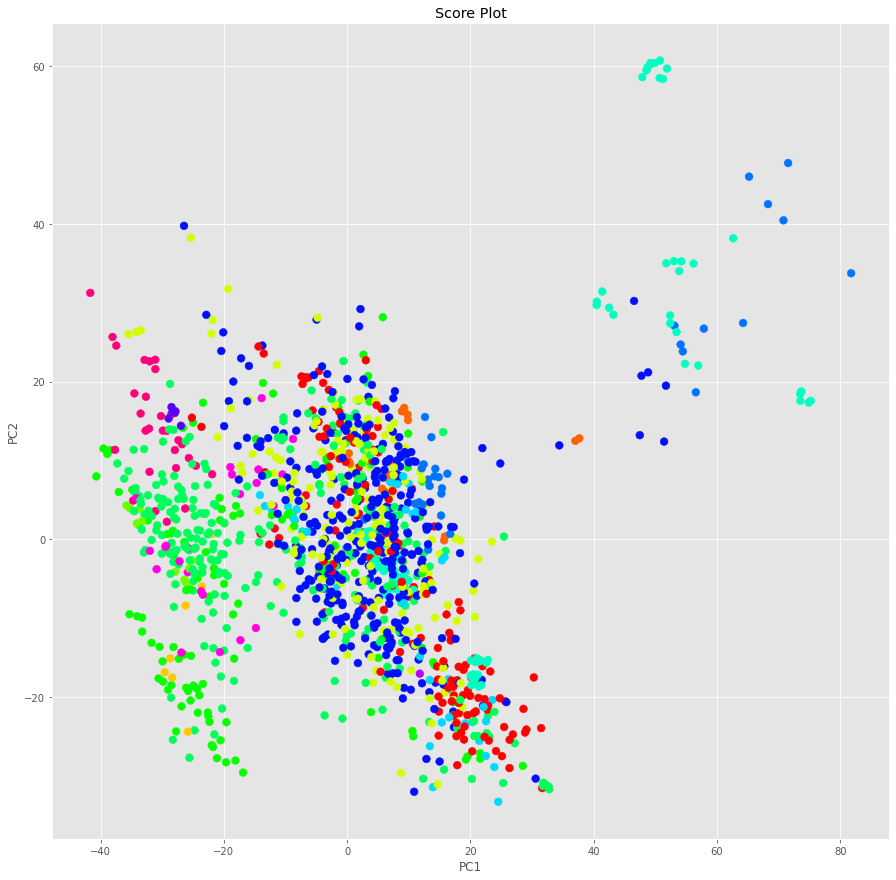

"colors = [plt.cm.jet(float(i)/max(m)) for i in m]\nfig = plt.figure(figsize=(15,15))\nwith plt.style.context(('ggplot')):\n    plt.scatter(T[:, 0], T[:, 1], c=colors, edgecolors='k', s=60)\n    plt.xlabel('PC1')\n    plt.ylabel('PC2')\n    #plt.xlim((-120, 120))\n    #plt.ylim((-120, 120))\n    plt.title('Score Plot')\nplt.show()"

In [68]:
pca = PCA()
 
# Run PCA on scaled data and obtain the scores array
T = pca.fit_transform(StandardScaler().fit_transform(X_val))

robust_cov = MinCovDet().fit(T[:,:5])
 
# Get the Mahalanobis distance
m = robust_cov.mahalanobis(T[:,:5])

color = d_asta['color'].values

scat_plot(T[:,0],T[:,1],color)

"""colors = [plt.cm.jet(float(i)/max(m)) for i in m]
fig = plt.figure(figsize=(15,15))
with plt.style.context(('ggplot')):
    plt.scatter(T[:, 0], T[:, 1], c=colors, edgecolors='k', s=60)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    #plt.xlim((-120, 120))
    #plt.ylim((-120, 120))
    plt.title('Score Plot')
plt.show()"""

C:\Users\Admin\AppData\Local\Temp/ipykernel_14624/678713913.py:1: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.figure(figsize=(16,10)).gca(projection='3d')


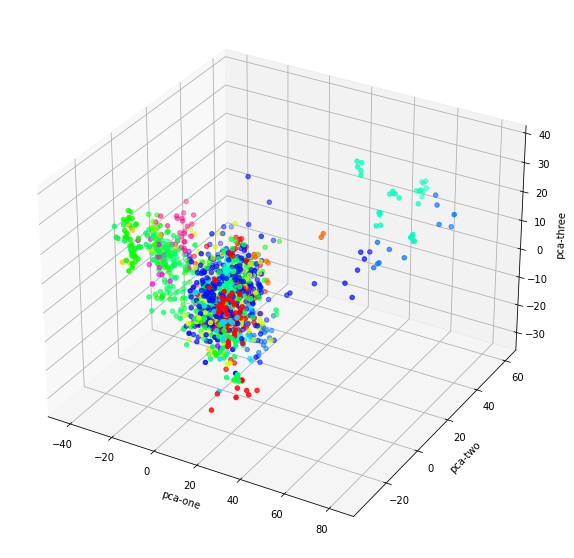

In [70]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs= T[:,0],
    ys= T[:,1], 
    zs= T[:,2],
    c= color
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

##### Dropping Outliers and then plotting the new scatter plot

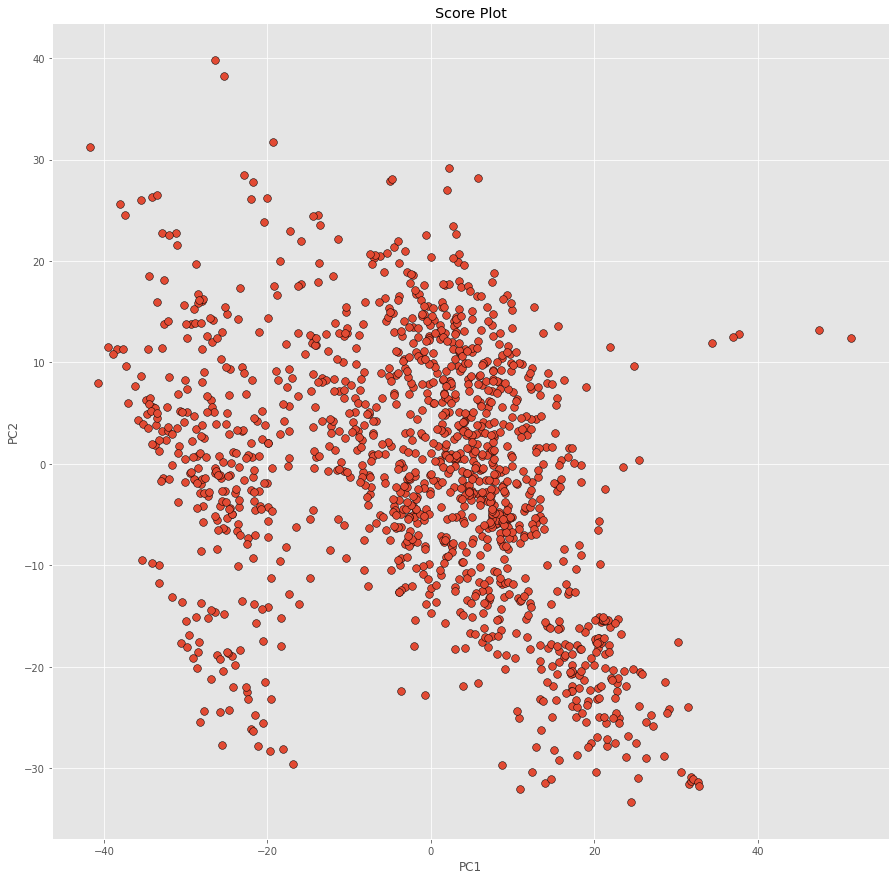

In [149]:
d_asta['mahan'] = m
d_asta['p'] = 1 - chi2.cdf(d_asta['mahan'], 4)
d_asta['ind'] = np.arange(len(m))
d_asta['PC0'] = T[:,0]

d_asta_1 = d_asta.query('p == 0.e+00')
#d_asta_1 = d_asta.query('PC0>60')
d_asta_2 = d_asta.drop(d_asta_1.index)
ind = d_asta_1['ind'].values

m_1 = np.delete(m,ind)

T_0 = np.delete(T[:,0],ind)
T_1 = np.delete(T[:,1],ind)

scat_plot(m_1,T_0,T_1)

#### Outliers Spectra and Histogram

<AxesSubplot:>

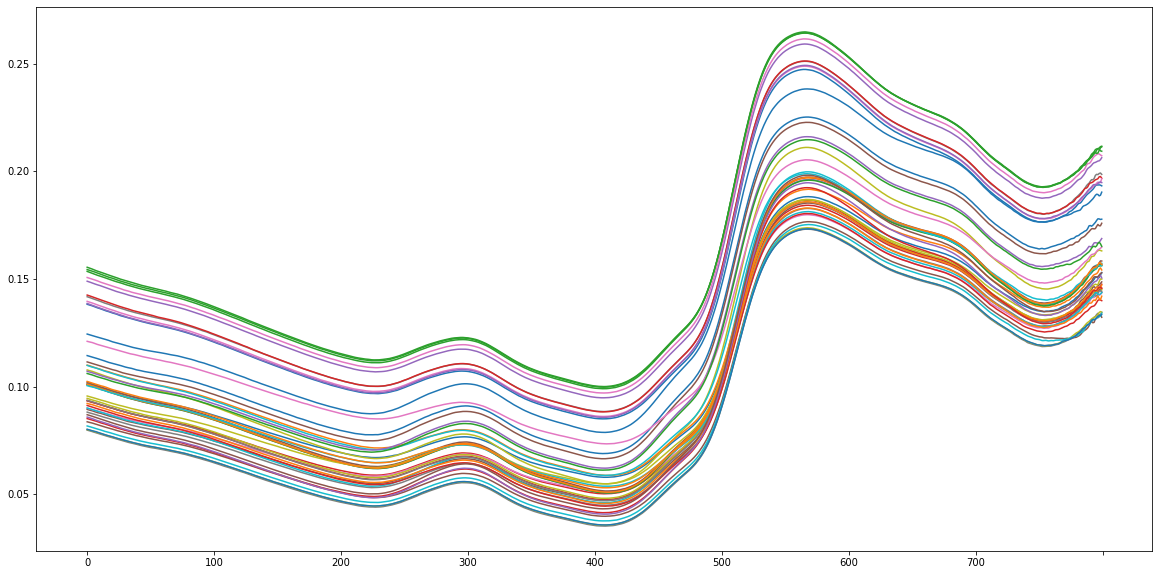

In [150]:
d_asta_1.drop(columns = ['fiber','mahan','ind','p','PC0']).transpose().plot(figsize=(20,10),legend = False)

<AxesSubplot:>

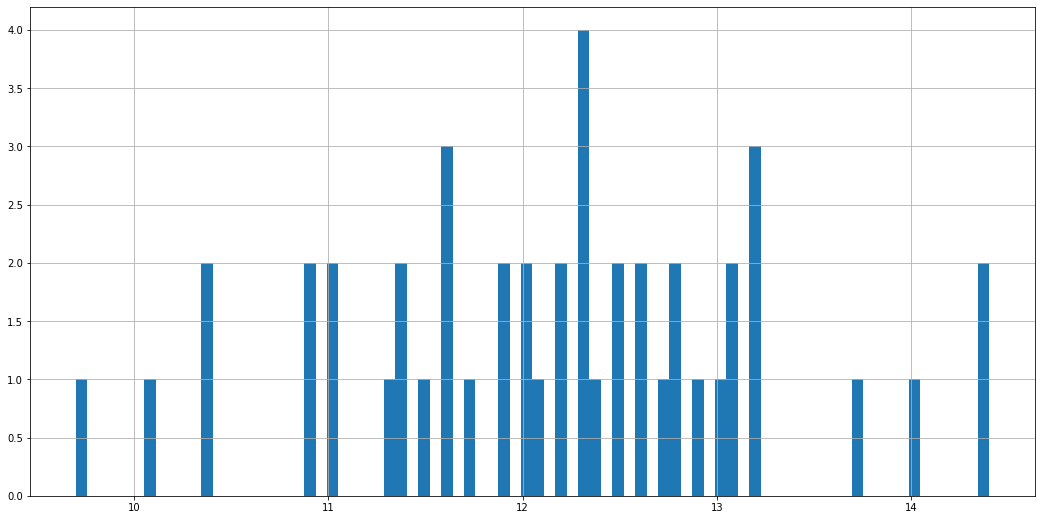

In [152]:
d_asta_1['fiber'].hist(bins = round(r2-r1)*10,figsize=(18,9))

#### Inliers Spectra and Histogram

<AxesSubplot:>

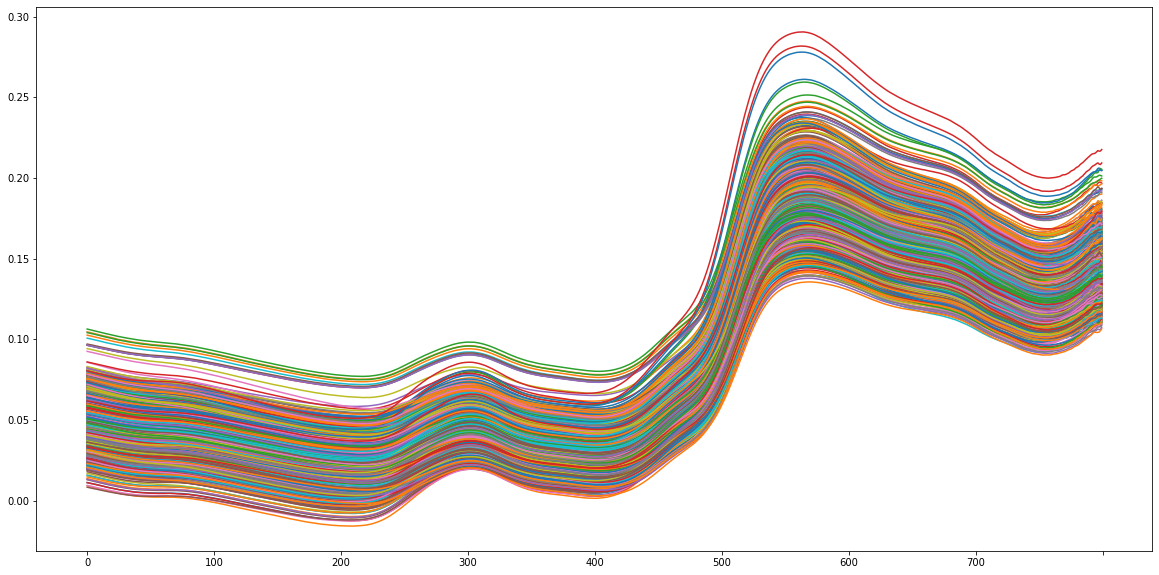

In [153]:
d_asta_2.drop(columns = ['fiber','mahan','ind','p','PC0']).transpose().plot(figsize=(20,10),legend = False)

<AxesSubplot:>

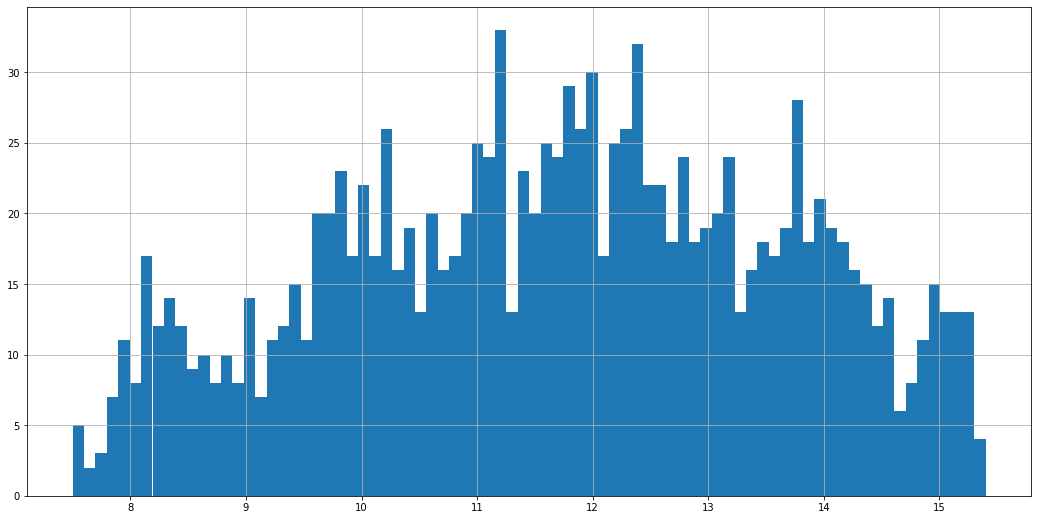

In [154]:
d_asta_2['fiber'].hist(bins = round(r2-r1)*10,figsize=(18,9))

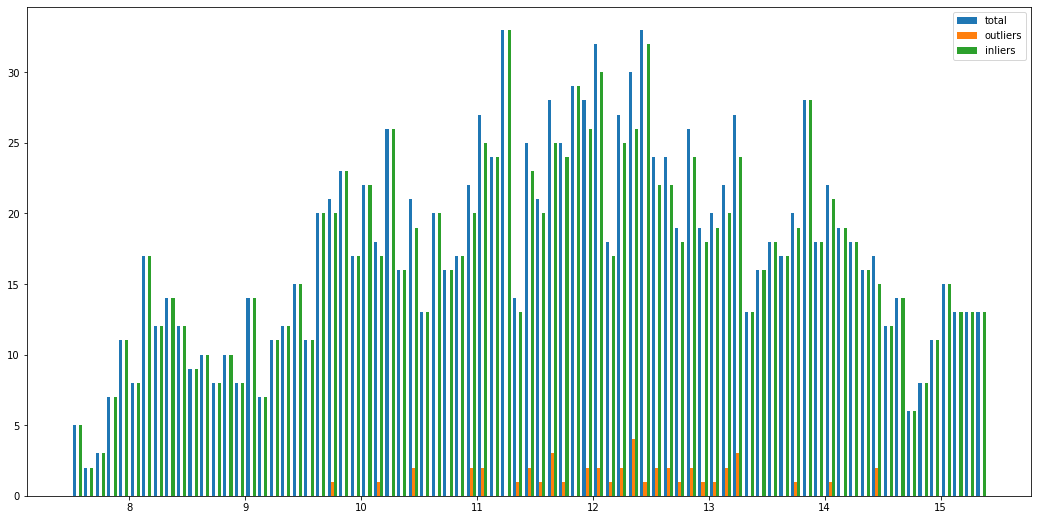

In [155]:
bins = np.arange(r1,r2,0.1)
total = d_asta['fiber'].values
outliers = d_asta_1['fiber'].values
inliers = d_asta_2['fiber'].values
plt.figure(figsize = (18,9))
plt.hist([total,outliers,inliers],bins,label =['total','outliers','inliers'])
plt.legend()

In [156]:
d_asta_1['mahan'].values

array([148.55126473, 161.29367902, 231.41318646, 116.68106179,
       164.22292036, 107.98270251,  97.9194731 , 108.11377896,
       204.28774816, 104.46557263, 215.62253972, 258.02300071,
       165.88350881, 133.35595254, 230.28202435, 164.65377365,
       220.24407158, 220.79472774, 105.33086991, 232.88960178,
        97.82302872, 159.43037322, 226.95041607, 210.90387916,
        93.17254743,  93.11117505, 210.34548267, 139.27023233,
       135.05064698, 217.56799327,  93.28866796, 232.39103225,
       223.1037359 , 148.17618464, 197.86822011, 113.86930424,
       226.74439056, 132.50178036, 136.57300936, 111.141476  ,
       126.31086606, 141.4911508 ,  91.54081225,  99.67634566,
        93.44710613,  86.07329487])

In [157]:
d_asta_1['p'].values

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

#### to plot outliers from inliners were outliers have p=0 in chi distribution

"for i in range(data_c_1_t.shape[0]):\n    if(data_c_1_t.iloc[i][0]==l1[0]):\n        data_c_1_t.iloc[i][1:].plot.line(ax=ax,color='red',label = str(l1[0]))\n    else:\n        data_c_1_t.iloc[i][1:].plot.line(ax=ax,color='green',label = str(l1[1]))\nimport matplotlib.patches as mpatches\n\n\nred_patch = mpatches.Patch(color='red', label=l1[0])\nblue_patch = mpatches.Patch(color='green', label=l1[1])\n\nax.legend(handles=[red_patch, blue_patch])\nfig_d_plot = fig.get_figure()\n# directory to save file\ndirt = 'C:\\Users\\Admin\\Desktop\\samples_report\\CHILI-001\\'+'d1 and d2'+'.png'\nfig_d_plot.savefig(dirt)"

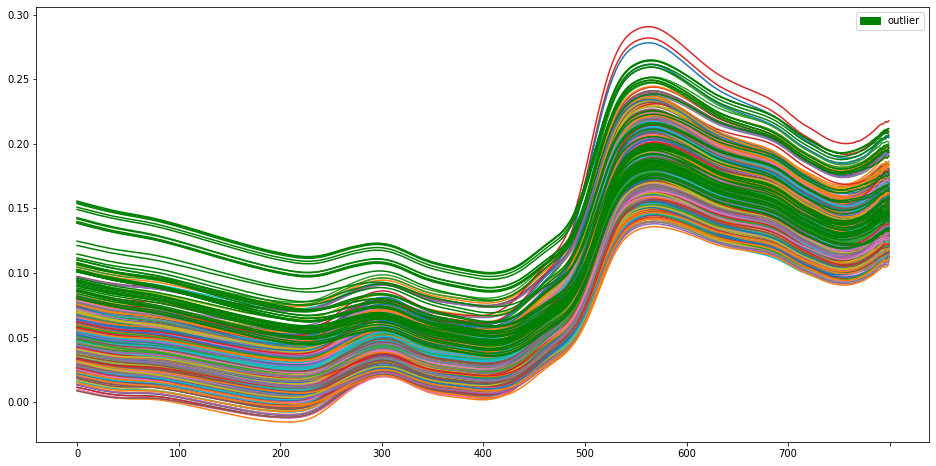

In [158]:
fig = plt.figure(figsize = (16,8))
ax = fig.add_subplot(1,1,1)
"""for i,r in d_asta_2.iterrows():
    gg = [str(x) for x in range(0,800)]
    ax.plot(r[gg].values,color = 'pink',label = 'inliner')"""

d_asta_2.drop(columns = ['fiber','mahan','ind','p','PC0']).transpose().plot(ax = ax,legend = False)

for i,r in d_asta_1.iterrows():
    gg = [str(x) for x in range(0,800)]
    ax.plot(r[gg].values,color = 'green',label = 'outlier')

import matplotlib.patches as mpatches
#red_patch = mpatches.Patch(color='pink', label='inliner')
blue_patch = mpatches.Patch(color='green', label='outlier')

ax.legend(handles=[blue_patch])

"""for i in range(data_c_1_t.shape[0]):
    if(data_c_1_t.iloc[i][0]==l1[0]):
        data_c_1_t.iloc[i][1:].plot.line(ax=ax,color='red',label = str(l1[0]))
    else:
        data_c_1_t.iloc[i][1:].plot.line(ax=ax,color='green',label = str(l1[1]))
import matplotlib.patches as mpatches


red_patch = mpatches.Patch(color='red', label=l1[0])
blue_patch = mpatches.Patch(color='green', label=l1[1])

ax.legend(handles=[red_patch, blue_patch])
fig_d_plot = fig.get_figure()
# directory to save file
dirt = 'C:\\Users\\Admin\\Desktop\\samples_report\\CHILI-001\\'+'d1 and d2'+'.png'
fig_d_plot.savefig(dirt)"""

#### Training and testing data split

In [159]:
d_asta_3 = d_asta_2.drop(columns = ['mahan','p','ind','PC0'])

In [223]:
X_train = []
X_val = []
Y_train = []
Y_val = []

y = np.zeros((int(r2-r1))*10,dtype=np.int32)
labels = d_asta_3['fiber'].values
print(labels)
for label in labels:
    y[round((label - r1)*10)]+=1
    
print(y.shape)

"""value_dict = {x:0 for x in range(r1,r2)}
labels = d_asta_2['ASTA']
        
for label in labels:
    value_dict[(int(label))]+=1"""

#l_1 = np.array([x for x in value_dict.values()])

for i in range(len(y)):
    if(y[i]>1):
        print(round(i*0.1+r1,1))
        qr = 'fiber=='+str(round(i*0.1+r1,1))
        data_asta_3 = d_asta_3.query(qr)
        data_asta_3_2 = data_asta_3.sample(n=1 ,random_state = sed)
        data_asta_3_1 = data_asta_3.drop(data_asta_3_2.index)
        
    X_train.append(np.array(data_asta_3_1.drop(columns = ['fiber'])))
    Y_train.append(np.array(data_asta_3_1['fiber']))
    X_val.append(np.array(data_asta_3_2.drop(columns = ['fiber'])))
    Y_val.append(np.array(data_asta_3_2['fiber']))
    
X_train = np.vstack(X_train)
Y_train = np.hstack(Y_train)
X_val = np.vstack(X_val)
Y_val = np.hstack(Y_val)

[15.4 15.4 15.4 ...  7.5  7.5  7.5]
(80,)
7.5
7.6
7.7
7.8
7.9
8.0
8.1
8.2
8.3
8.4
8.5
8.6
8.7
8.8
8.9
9.0
9.1
9.2
9.3
9.4
9.5
9.6
9.7
9.8
9.9
10.0
10.1
10.2
10.3
10.4
10.5
10.6
10.7
10.8
10.9
11.0
11.1
11.2
11.3
11.4
11.5
11.6
11.7
11.8
11.9
12.0
12.1
12.2
12.3
12.4
12.5
12.6
12.7
12.8
12.9
13.0
13.1
13.2
13.3
13.4
13.5
13.6
13.7
13.8
13.9
14.0
14.1
14.2
14.3
14.4
14.5
14.6
14.7
14.8
14.9
15.0
15.1
15.2
15.3
15.4


In [187]:
y

array([ 5,  2,  3,  7, 11,  8, 17, 12, 14, 12,  9, 10,  8, 10,  8, 14,  7,
       11, 12, 15, 11, 20, 20, 23, 17, 22, 17, 26, 16, 19, 13, 20, 16, 17,
       20, 25, 24, 33, 13, 23, 20, 25, 24, 29, 26, 30, 17, 25, 26, 32, 22,
       22, 18, 24, 18, 19, 20, 24, 13, 16, 18, 17, 19, 28, 18, 21, 19, 18,
       16, 15, 12, 14,  6,  8, 11, 15, 13, 13, 13,  4])

In [188]:
y_11 = y - 1

In [189]:
y_11[y_11<0] = 0

In [190]:
y_11

array([ 4,  1,  2,  6, 10,  7, 16, 11, 13, 11,  8,  9,  7,  9,  7, 13,  6,
       10, 11, 14, 10, 19, 19, 22, 16, 21, 16, 25, 15, 18, 12, 19, 15, 16,
       19, 24, 23, 32, 12, 22, 19, 24, 23, 28, 25, 29, 16, 24, 25, 31, 21,
       21, 17, 23, 17, 18, 19, 23, 12, 15, 17, 16, 18, 27, 17, 20, 18, 17,
       15, 14, 11, 13,  5,  7, 10, 14, 12, 12, 12,  3])

In [224]:
y_11.shape

(80,)

In [191]:
d_asta_train = pd.DataFrame(X_train)
d_asta_train['fiber'] = Y_train

d_asta_test = pd.DataFrame(X_val)
d_asta_test['fiber'] = pd.DataFrame(Y_val)

In [192]:
d_asta_train.to_csv('dorb_train_2.csv')
d_asta_test.to_csv('dorb_test_2.csv')

<AxesSubplot:>

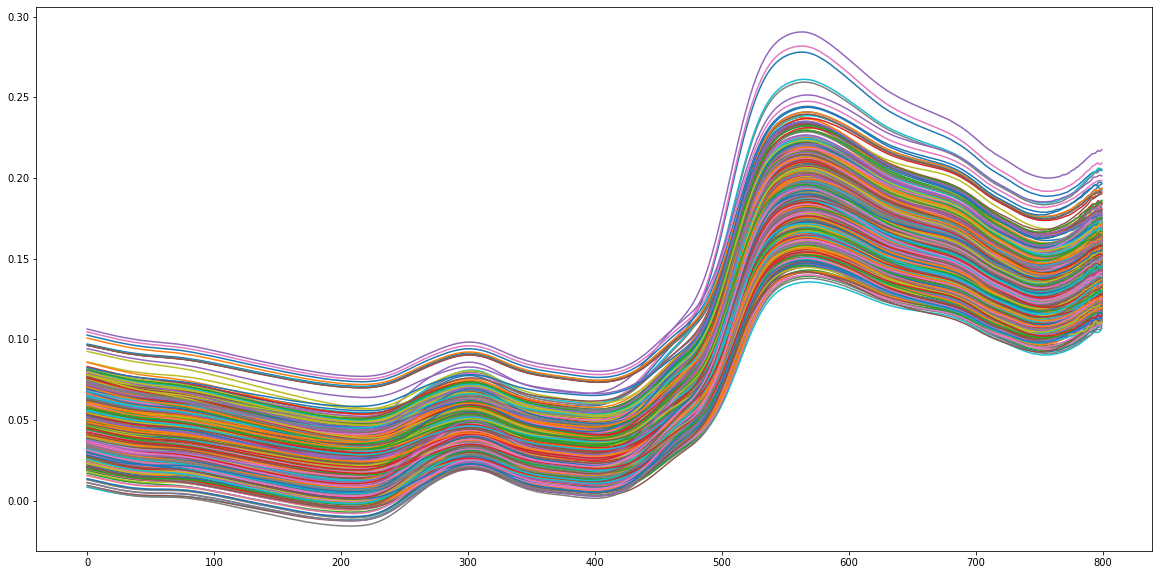

In [193]:
d_asta_train.drop(columns = ['fiber']).transpose().plot(figsize=(20,10),legend = False)

<AxesSubplot:>

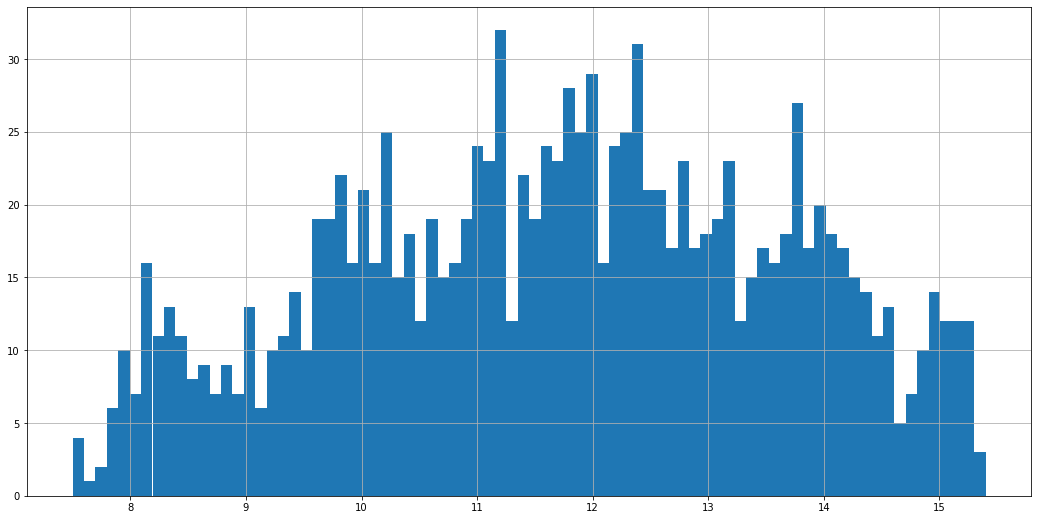

In [194]:
d_asta_train['fiber'].hist(bins = round(r2-r1)*10,figsize=(18,9))

<AxesSubplot:>

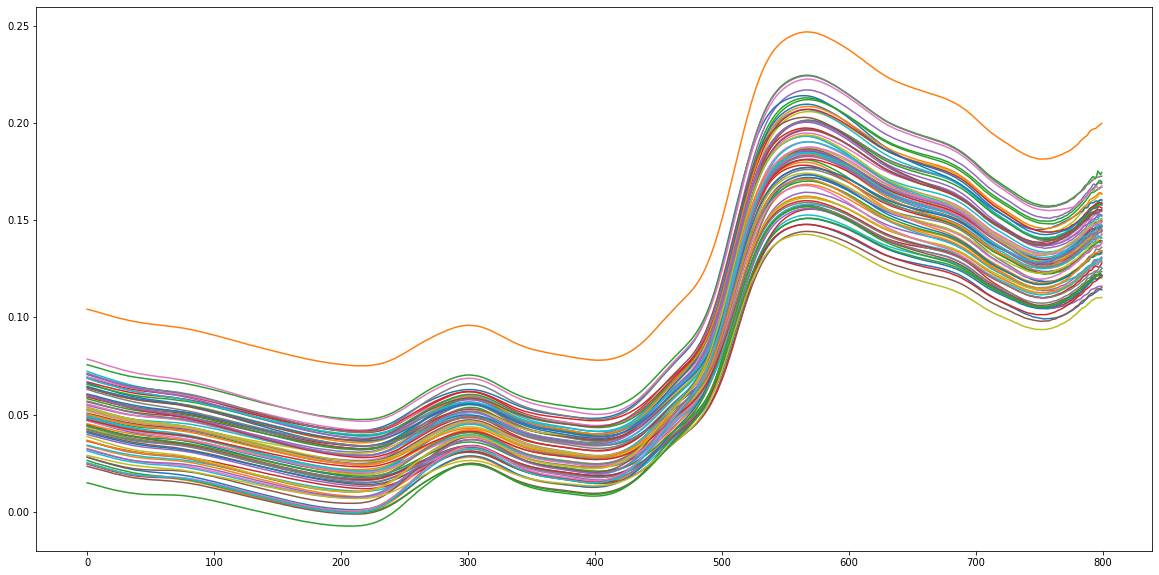

In [195]:
d_asta_test.drop(columns = ['fiber']).transpose().plot(figsize=(20,10),legend = False)

<AxesSubplot:>

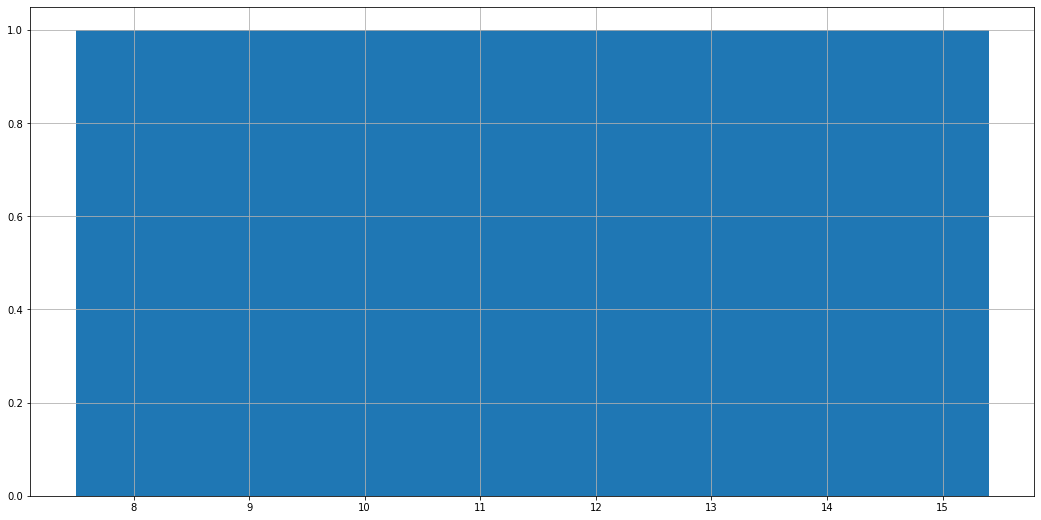

In [197]:
d_asta_test['fiber'].hist(bins = round(r2-r1)*10,figsize=(18,9))

#### combined train and test spectra

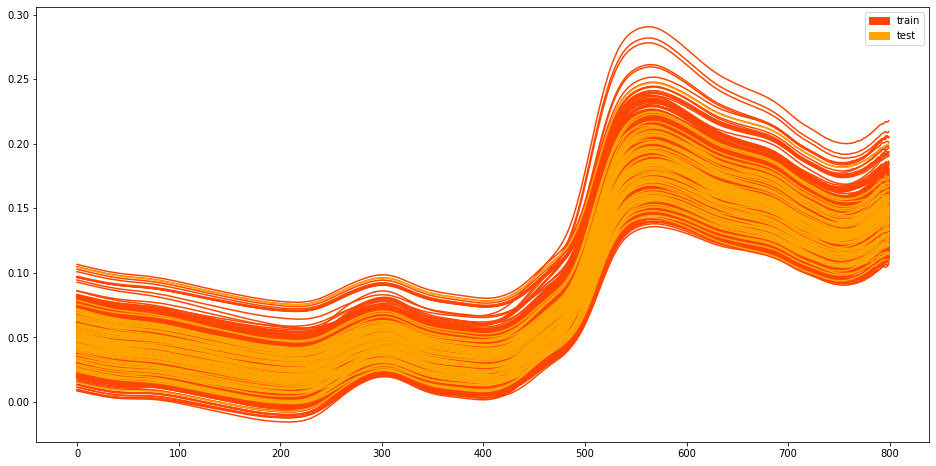

In [198]:
fig = plt.figure(figsize = (16,8))
ax = fig.add_subplot(1,1,1)
for i,r in d_asta_train.iterrows():
    gg = [x for x in range(0,800)]
    ax.plot(r[gg].values,color = 'orangered',label = 'train')

for i,r in d_asta_test.iterrows():
    gg = [x for x in range(0,800)]
    ax.plot(r[gg].values,color = 'orange',label = 'test')

import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='orangered', label='train')
blue_patch = mpatches.Patch(color='orange', label='test')

ax.legend(handles=[red_patch,blue_patch])

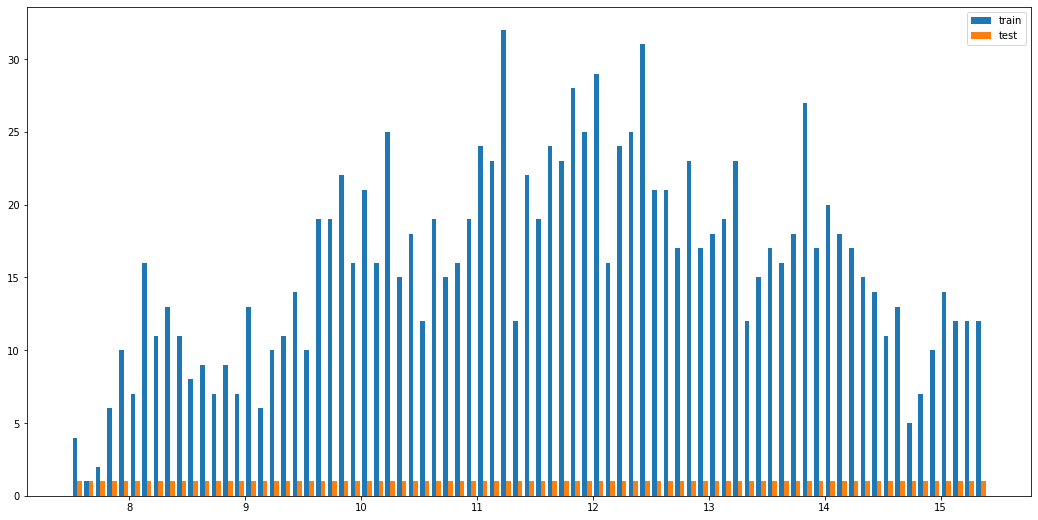

In [199]:
bins = np.arange(r1,r2,0.1)
train = d_asta_train['fiber'].values
test = d_asta_test['fiber'].values
plt.figure(figsize = (18,9))
plt.hist([train,test],bins,label =['train','test'])
plt.legend()

#### Applying Label Distribution Smoothing to the Training Data Distribution

In [218]:
wt,smooted_val,window = get_weights(y_11,11,2)

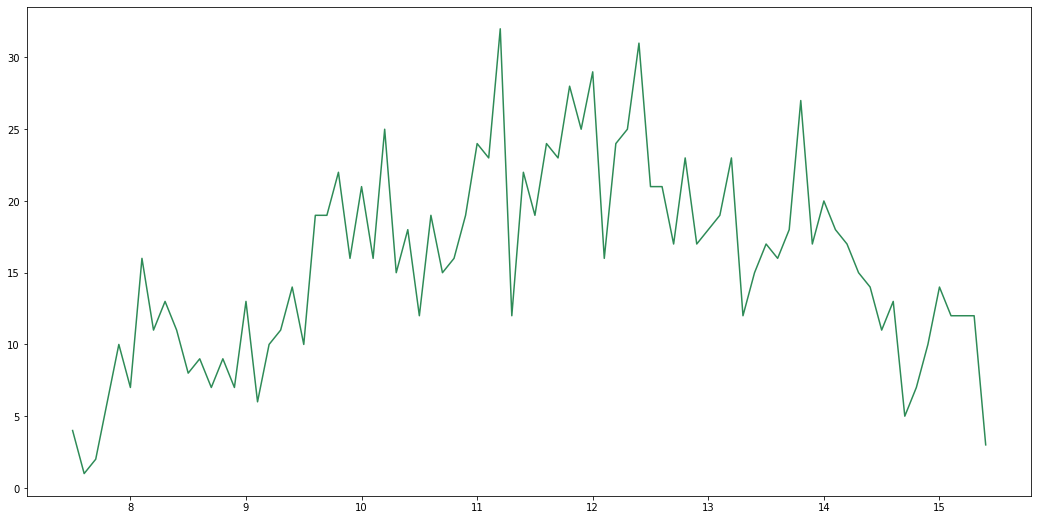

In [207]:
plt.figure(figsize = (18,9))
plt.plot(np.arange(r1,r2,0.1),y_11,color='seagreen')

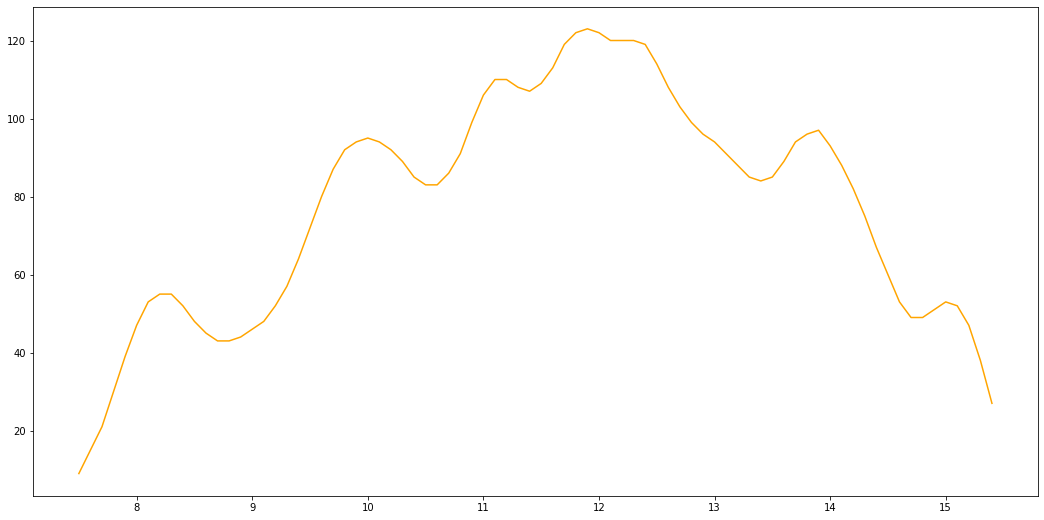

In [219]:
plt.figure(figsize = (18,9))
plt.plot(np.arange(r1,r2,0.1),smooted_val,color='orange')

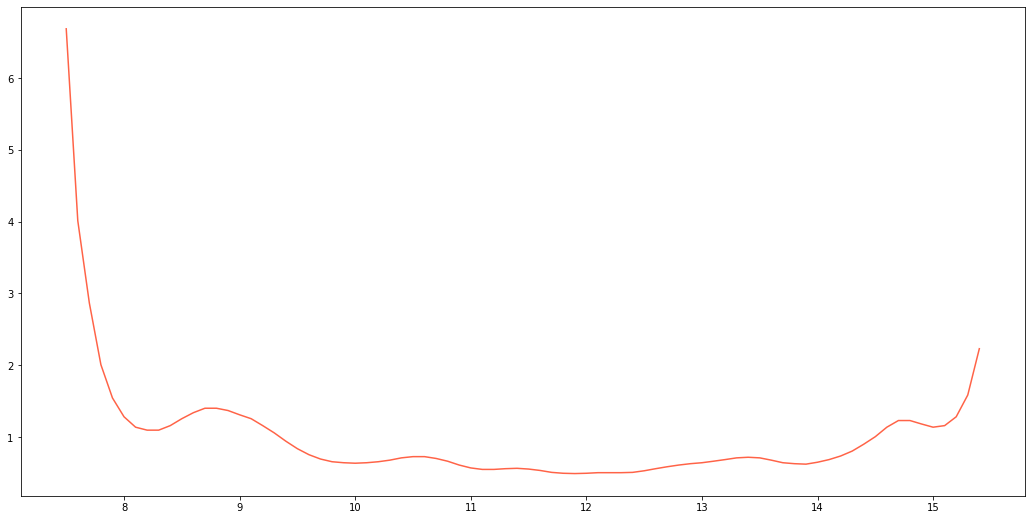

In [220]:
plt.figure(figsize = (18,9))
plt.plot(np.arange(r1,r2,0.1),wt,color='tomato')

In [222]:
wt

[6.684723644904102,
 4.0108343662407195,
 2.864881594119304,
 2.0054171831203598,
 1.5426285420595167,
 1.2800534138478141,
 1.1351417594789162,
 1.0938638263790412,
 1.0938638263790412,
 1.1569714345599904,
 1.2533857114348719,
 1.3369447513931028,
 1.399128189110894,
 1.399128189110894,
 1.3673298670198604,
 1.307880727750117,
 1.2533857114348719,
 1.1569714345599904,
 1.0554826807743318,
 0.940039255560801,
 0.8355904556130127,
 0.752031415654782,
 0.6915231279513614,
 0.6539403638750585,
 0.6400267069239071,
 0.6332896308768815,
 0.6400267069239071,
 0.6539403638750585,
 0.6759832918227981,
 0.7077942768533657,
 0.7248495194537714,
 0.7248495194537714,
 0.699564094555447,
 0.6611265260298936,
 0.6077021444430359,
 0.5675708797394581,
 0.5469319131895206,
 0.5469319131895206,
 0.5570603037420084,
 0.5622664528116567,
 0.5519496309952183,
 0.5324116117855614,
 0.5055673566183201,
 0.4931353196233517,
 0.4891260984931954,
 0.4931353196233517,
 0.5013542957800899,
 0.5013542957800899,


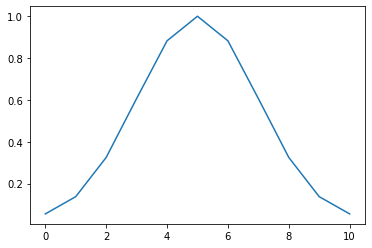

In [221]:
plt.plot(window)

In [222]:
import sklearn.metrics as met

In [207]:
sdf = pd.read_csv('C:/Users/Admin/Desktop/best_asta_lds_csv/chili_train_actual_pred_lds.csv',encoding = 'utf-8')

In [218]:
sdf = sdf.dropna()

In [219]:
sdf

Unnamed: 0  actual  predcted  MAE   MAPE
0         164.0    40.0      38.0  2.0  95.00
1         389.0    40.0      31.0  9.0  77.50
2         130.0    41.0      44.0  3.0  92.68
3         235.0    41.0      42.0  1.0  97.56
4         499.0    41.0      40.0  1.0  97.56
..          ...     ...       ...  ...    ...
731       205.0   119.0     113.0  6.0  94.96
732       293.0   119.0     110.0  9.0  92.44
733       453.0   119.0     113.0  6.0  94.96
734       473.0   119.0     110.0  9.0  92.44
735       649.0   119.0     113.0  6.0  94.96

[736 rows x 5 columns]

In [220]:
pred = np.asarray(sdf['predcted'])

In [221]:
act = np.asarray(sdf['actual'])

In [223]:
met.r2_score(pred,act)

0.8665196555297456

d_asta_test.to_csv('test_data.csv')

### Analysis of spectra from diff_test

In [283]:
sed = 100
r1 = 65
r2 = 66
df = pd.read_csv('diff_test.csv')
col = ['Sample ID','Cap','800']
#col = [str(x) for x in range(0,151)]+[str(x) for x in range(751,801)]+['Sample ID','Cap']
d_asta = df.drop(columns=col)
d_asta = d_asta.dropna(subset=['ASTA'])
d_asta['ASTA'] = d_asta['ASTA'].round()
d_asta = d_asta[d_asta['ASTA']>=r1]
d_asta = d_asta[d_asta['ASTA']<r2]

In [282]:
sed = 100
r1 = 65
r2 = 66
df = pd.read_csv('chili-001.csv')
col = ['Sample ID','Cap','800']
#col = [str(x) for x in range(0,151)]+[str(x) for x in range(751,801)]+['Sample ID','Cap']
d_asta_2 = df.drop(columns=col)
d_asta_2 = d_asta_2.dropna(subset=['ASTA'])
d_asta_2['ASTA'] = d_asta_2['ASTA'].round()
d_id = [*(set(d_asta_2['Device ID']))]
d_asta_2 = d_asta_2.query("ASTA>="+str(r1)+"&"+"ASTA<"+str(r2))
d_asta_3 = d_asta_2[d_asta_2["Device ID"] == str(d_id[0])]
d_asta_4 = d_asta_2[d_asta_2["Device ID"] == str(d_id[1])]

d_asta_3 = d_asta_3.drop(columns = ['Device ID'])
d_asta_4 = d_asta_4.drop(columns = ["Device ID"])

In [266]:
def prepro(X):
    X_val = savitzky(X,11,2)
    X_val = MSC(X_val)
    X_val = detrending(X_val)
    X_val = derivate_first(X_val,11,2)
    return X_val

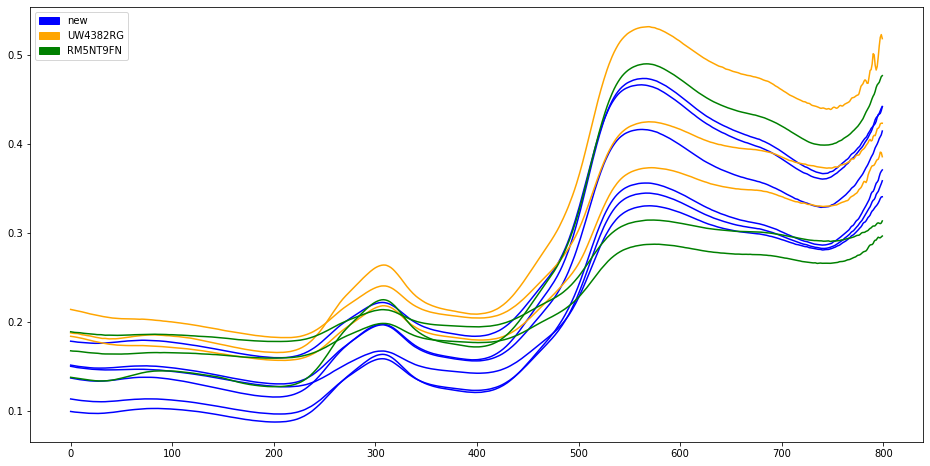

In [286]:
fig = plt.figure(figsize = (16,8))
ax = fig.add_subplot(1,1,1)

x_val_1 = np.array(d_asta.drop(columns = 'ASTA'))
x_val_2 = np.array(d_asta_3.drop(columns = 'ASTA'))
x_val_3 = np.array(d_asta_4.drop(columns = 'ASTA'))

ax.plot(x_val_1.transpose(),color = 'blue',label = 'new')
ax.plot(x_val_2.transpose(),color = 'orange',label = d_id[0])
ax.plot(x_val_3.transpose(),color = 'green',label = d_id[1])

import matplotlib.patches as mpatches
blue_patch = mpatches.Patch(color='blue', label='new')
orange_patch = mpatches.Patch(color='orange', label=d_id[0])
green_patch = mpatches.Patch(color='green', label=d_id[1])

ax.legend(handles=[red_patch,orange_patch,green_patch])

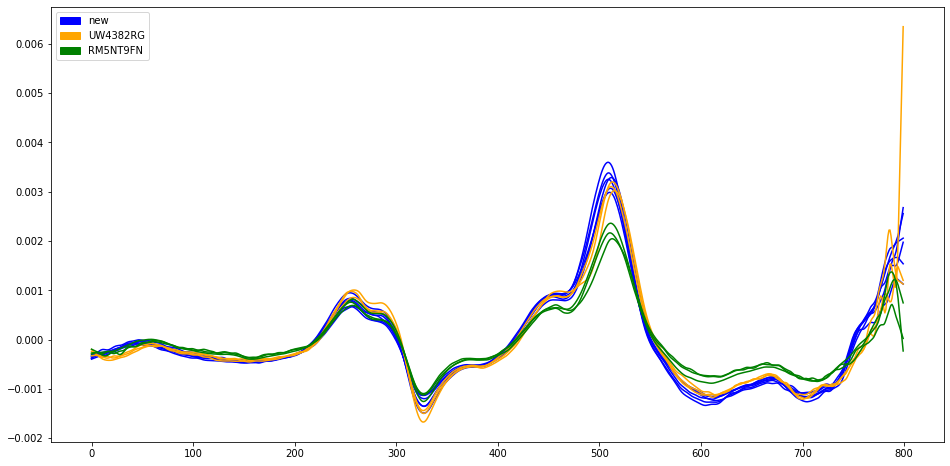

In [284]:
fig = plt.figure(figsize = (16,8))
ax = fig.add_subplot(1,1,1)

x_val_1 = prepro(np.array(d_asta.drop(columns = 'ASTA')))
x_val_2 = prepro(np.array(d_asta_3.drop(columns = 'ASTA')))
x_val_3 = prepro(np.array(d_asta_4.drop(columns = 'ASTA')))

ax.plot(x_val_1.transpose(),color = 'blue',label = 'new')
ax.plot(x_val_2.transpose(),color = 'orange',label = d_id[0])
ax.plot(x_val_3.transpose(),color = 'green',label = d_id[1])

import matplotlib.patches as mpatches
blue_patch = mpatches.Patch(color='blue', label='new')
orange_patch = mpatches.Patch(color='orange', label=d_id[0])
green_patch = mpatches.Patch(color='green', label=d_id[1])

ax.legend(handles=[red_patch,orange_patch,green_patch])

### Anlaysis of Khanna and Baramati DORB

In [43]:
sed = 100
#r1 = 7.5
#r2 = 15.5
df = pd.read_csv('bar_dorb_fiber.csv')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
col = ['abs re','Sample ID','pred']
d_asta = df.drop(columns=col)
d_asta = d_asta.dropna(subset=['fiber'])
#plant_list = [*set(d_asta['plant'])]
#d_asta['fiber'] = d_asta['fiber'].round(1)
#d_asta = d_asta[d_asta['fiber']>=r1]
#d_asta = d_asta[d_asta['fiber']<r2]

<AxesSubplot:>

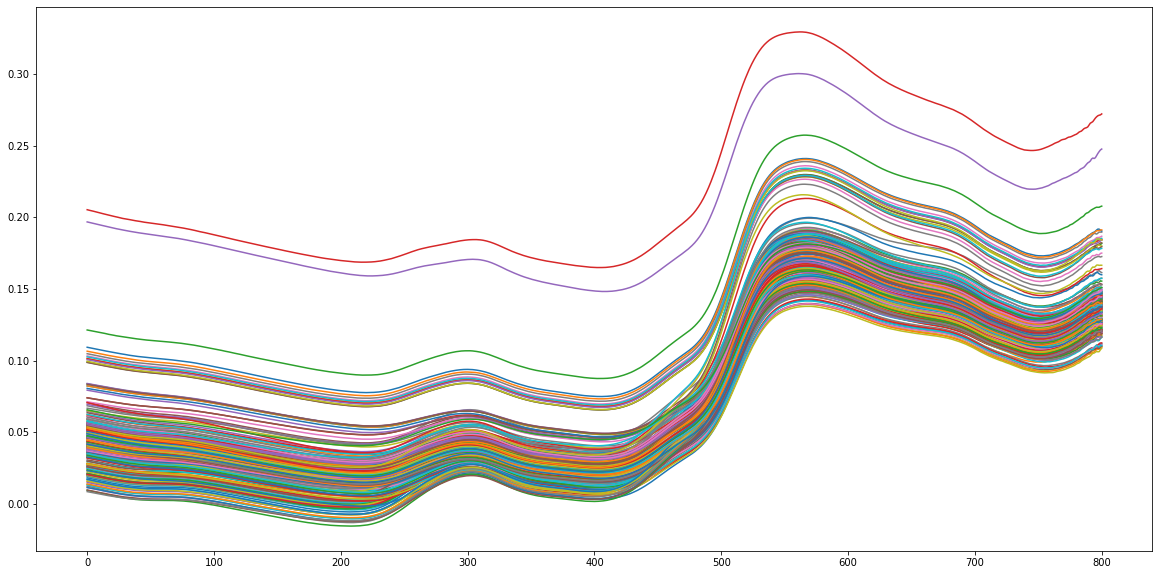

In [44]:
d_asta.drop(columns = ['fiber']).transpose().plot(figsize=(20,10),legend = False)

In [45]:
d_asta['color'] = 'red'

<AxesSubplot:>

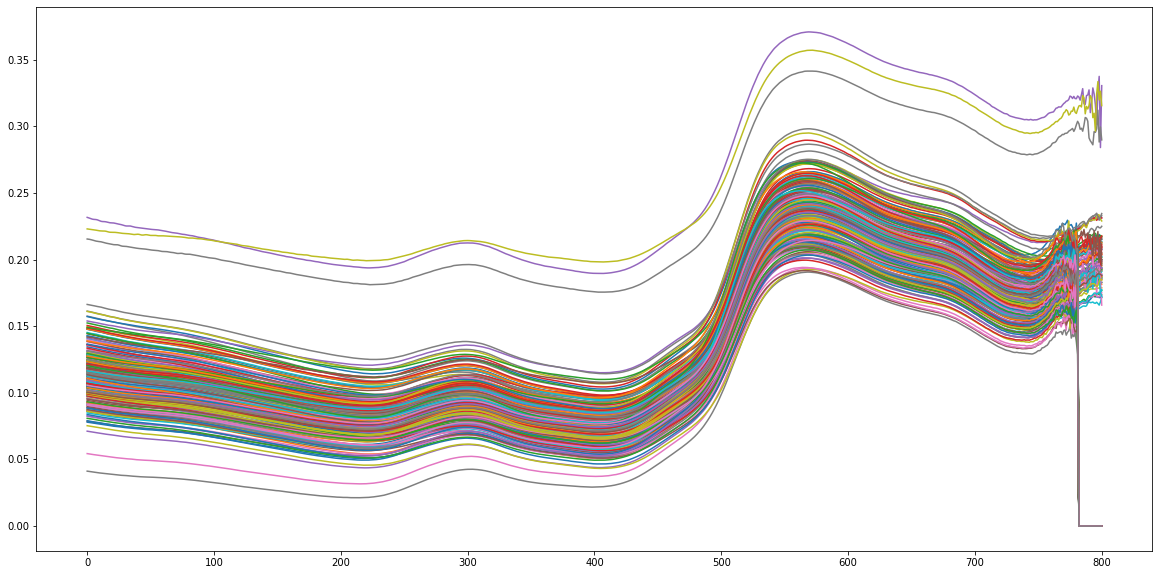

In [46]:
df_1 = pd.read_csv('khan_dorb_fiber.csv')
df_1 = df_1.loc[:, ~df_1.columns.str.contains('^Unnamed')]
col = ['abs re','Sample ID','pred']
d_asta_1 = df_1.drop(columns=col)
d_asta_1 = d_asta_1.dropna(subset=['fiber'])
d_asta_1.drop(columns = ['fiber']).transpose().plot(figsize=(20,10),legend = False)

In [47]:
d_asta_1['color'] = 'green'

In [48]:
d_asta = pd.concat([d_asta,d_asta_1],axis = 0)

In [49]:
d_asta

fiber         0         1         2         3         4         5  \
0    15.57  0.049217  0.049087  0.048946  0.048793  0.048624  0.048441   
1    15.68  0.049005  0.048821  0.048629  0.048437  0.048252  0.048078   
2    14.95  0.043301  0.043162  0.043020  0.042865  0.042687  0.042484   
3    15.05  0.044055  0.043885  0.043750  0.043626  0.043487  0.043313   
4    15.24  0.045179  0.044994  0.044818  0.044644  0.044463  0.044270   
..     ...       ...       ...       ...       ...       ...       ...   
243  13.26  0.107103  0.106919  0.106743  0.106574  0.106411  0.106255   
244  14.18  0.102078  0.101909  0.101729  0.101556  0.101412  0.101304   
245  13.55  0.100342  0.100196  0.100037  0.099875  0.099717  0.099569   
246  13.91  0.105643  0.105456  0.105258  0.105070  0.104911  0.104791   
247  14.98  0.101929  0.101756  0.101565  0.101374  0.101202  0.101057   

            6         7         8  ...       792       793       794  \
0    0.048250  0.048058  0.047873  ...  0.144950  0.145481  0.146269   
1    0.047907  0.047725  0.047524  ...  0.142372  0.142628  0.142819   
2    0.042278  0.042101  0.041975  ...  0.139051  0.138865  0.138571   
3    0.043115  0.042910  0.042713  ...  0.139255  0.139688  0.140261   
4    0.044073  0.043883  0.043710  ...  0.139531  0.139776  0.140755   
..        ...       ...       ...  ...       ...       ...       ...   
243  0.106102  0.105950  0.105796  ...  0.000000  0.000000  0.000000   
244  0.101208  0.101096  0.100945  ...  0.000000  0.000000  0.000000   
245  0.099427  0.099285  0.099141  ...  0.000000  0.000000  0.000000   
246  0.104688  0.104577  0.104434  ...  0.000000  0.000000  0.000000   
247  0.100929  0.100803  0.100665  ...  0.000000  0.000000  0.000000   

          795       796       797       798       799       800  color  
0    0.146576  0.146599  0.146975  0.147342  0.147418  0.147521    red  
1    0.143605  0.144441  0.144346  0.144097  0.144335  0.144606    red  
2    0.138850  0.139636  0.140387  0.140826  0.140869  0.140665    red  
3    0.140092  0.139862  0.140770  0.141484  0.141224  0.141288    red  
4    0.141720  0.142164  0.142028  0.142197  0.142786  0.142293    red  
..        ...       ...       ...       ...       ...       ...    ...  
243  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  green  
244  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  green  
245  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  green  
246  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  green  
247  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  green  

[553 rows x 803 columns]

In [50]:
r1,r2 = d_asta['fiber'].min() , d_asta['fiber'].max()

In [51]:
r1,r2

(8.06, 19.82)

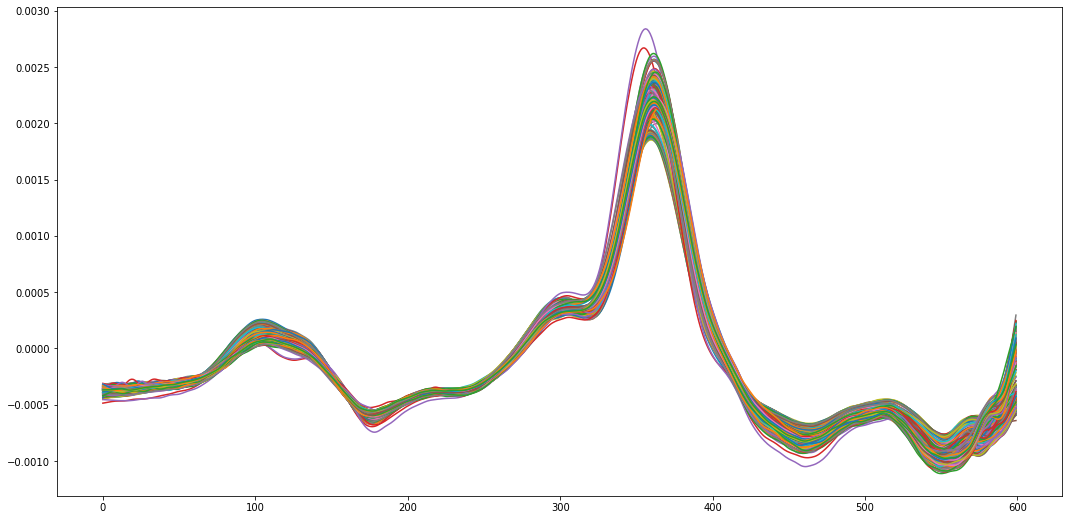

In [59]:
X_val = np.array(d_asta.drop(columns =['fiber','color']))
X_val = savitzky(X_val[:,150:750],11,2)
X_val = MSC(X_val)
X_val = detrending(X_val)
X_val = derivate_first(X_val,11,2)

fig = plt.figure(figsize=(18,9))
a = fig.add_subplot(1,1,1).plot(X_val.transpose())

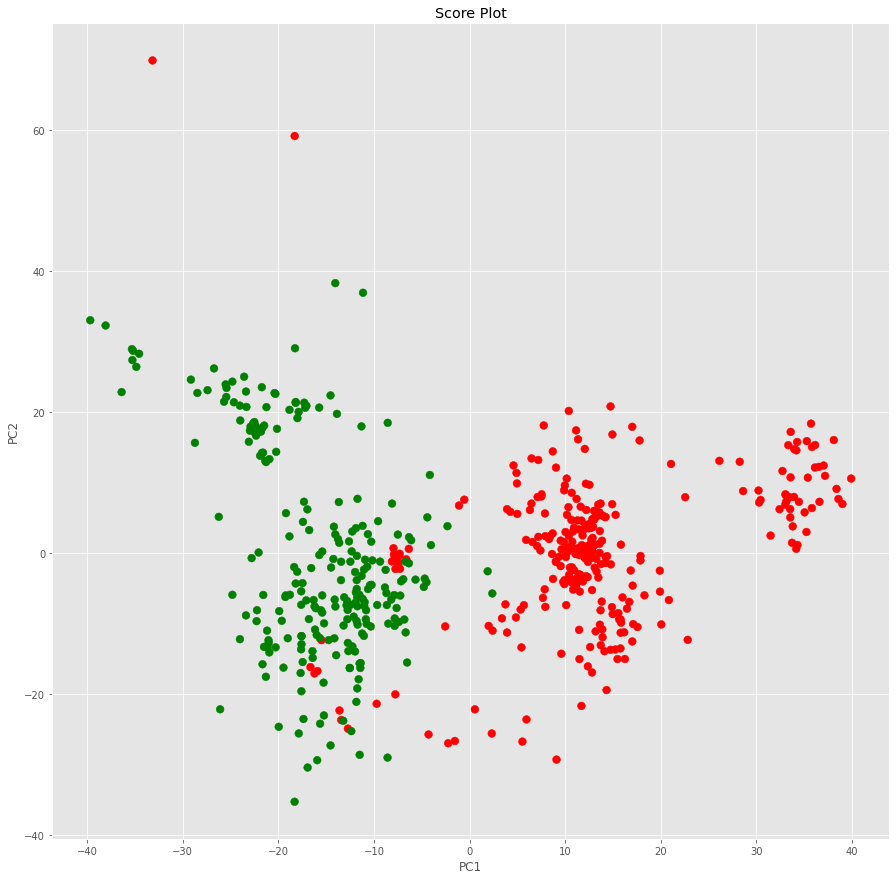

In [66]:
pca = PCA()
 
# Run PCA on scaled data and obtain the scores array
T = pca.fit_transform(StandardScaler().fit_transform(X_val))

robust_cov = MinCovDet().fit(T[:,:5])
 
# Get the Mahalanobis distance
m = robust_cov.mahalanobis(T[:,:5])

color = d_asta['color'].values

scat_plot(T[:,0],T[:,1],color)

C:\Users\Admin\AppData\Local\Temp/ipykernel_19756/678713913.py:1: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.figure(figsize=(16,10)).gca(projection='3d')


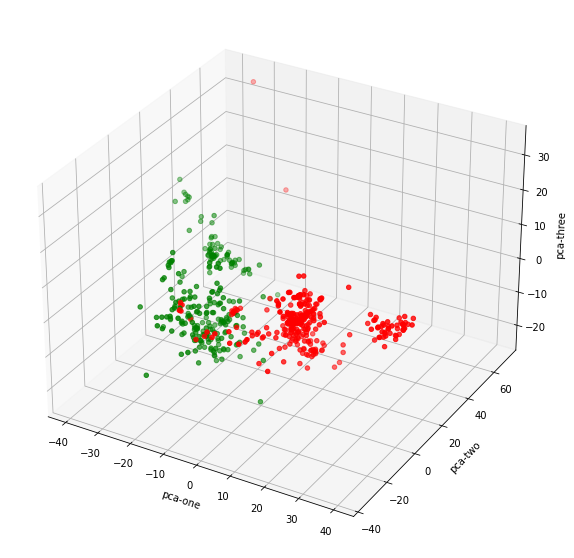

In [63]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs= T[:,0],
    ys= T[:,1], 
    zs= T[:,2],
    c= color
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

### Analysis of Khanna and Baramati DORB using PLSR components

#### preprocessing of the data using the best pipeline by pankaj on dorb fiber which is MSC ->SNV->SG-2DV (17,2)

In [84]:
from sklearn.cross_decomposition import PLSRegression

In [93]:
from pyChemometrics import ChemometricsScaler, ChemometricsPLS

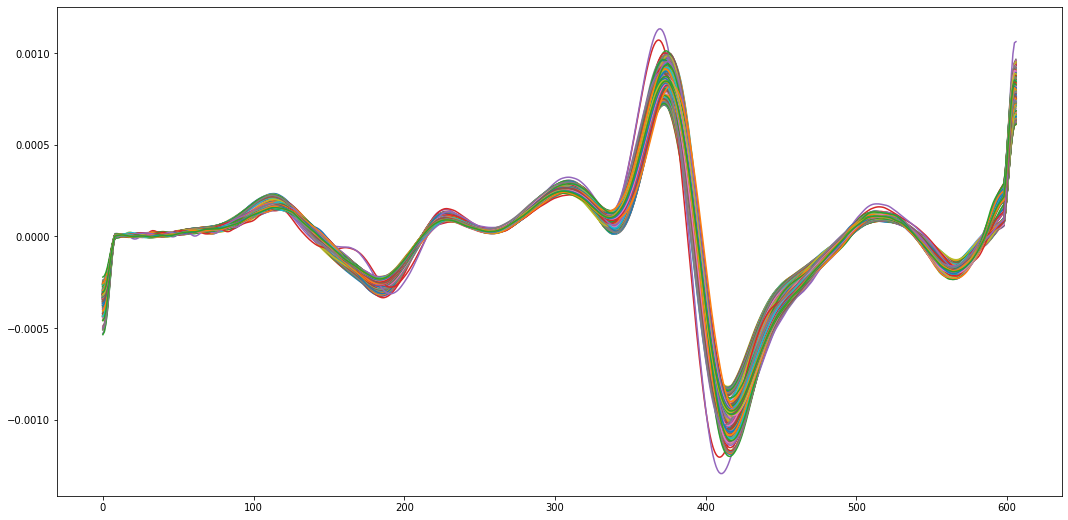

In [156]:
X_val = np.array(d_asta.drop(columns =['fiber','color']))
X_val = derivate_sec(snv(moving_smoothing(X_val[:,100:-60],17)),17,2)
fig = plt.figure(figsize=(18,9))
a = fig.add_subplot(1,1,1).plot(X_val[:,17:-17].transpose())

In [116]:
Y_val = d_asta['fiber'].values

In [157]:
pls_opt = PLSRegression(n_components = 9)
pls_opt.fit(X_val,Y_val)

PLSRegression(n_components=9)

In [158]:
y_pred = pls_opt.predict(X_val)

In [159]:
g = pls_opt.fit_transform(X_val,Y_val)

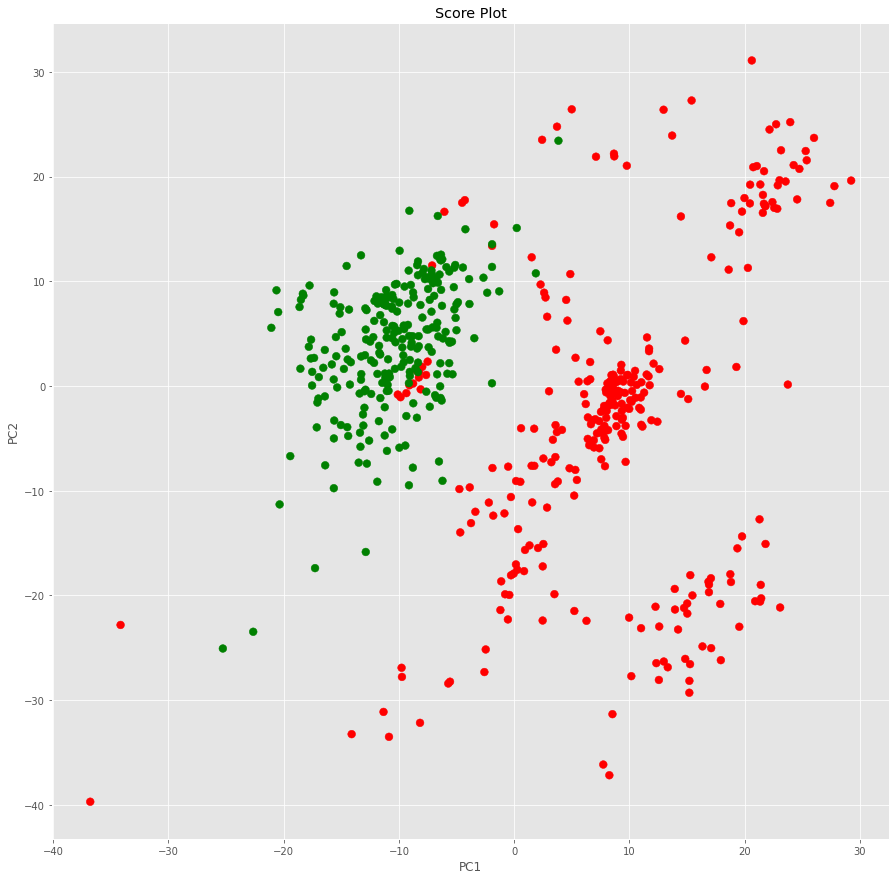

In [160]:
scat_plot(g[0][:,0],g[0][:,1],color)

C:\Users\Admin\AppData\Local\Temp/ipykernel_19756/315143787.py:1: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.figure(figsize=(16,10)).gca(projection='3d')


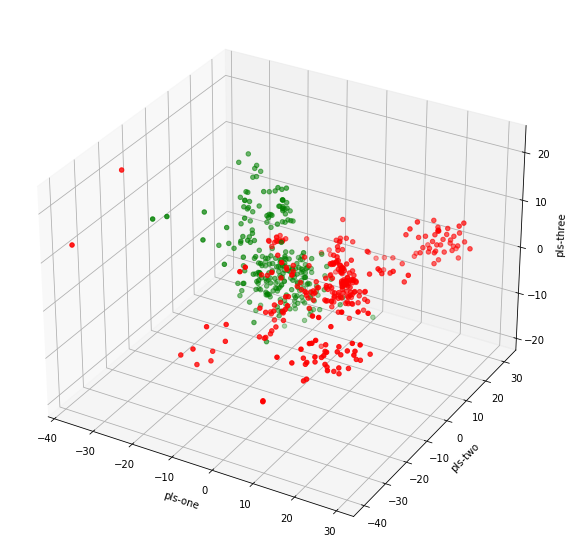

In [161]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs= g[0][:,0],
    ys= g[0][:,1], 
    zs= g[0][:,2],
    c= color
)
ax.set_xlabel('pls-one')
ax.set_ylabel('pls-two')
ax.set_zlabel('pls-three')
plt.show()